## DSSD front-back normalization

### Inter-strip correlation - crosstalk between neighbouring strips

$E = E_i + E_{i+1}$

![](dssd-n3.png)

### Front-back correlation neglecting crosstalks
$E_i = E_j$
![](dssd-fb.png)

front-back correlation 可用于将DSSD的所有条的能量归一到其中某一条的能量。

### Normalization

对于入射到 $(xstrip=i ,ystrip=j)$的能量沉积为E的粒子:

$$E_i=a'_iA_i+b'_i$$

$$E_j=a'_jA_j+b'_j$$

$$E=E_i=E_j => A_i=a_iA_j+b_i$$

同理，对于$(i+1, j)$: $ A_{i+1}=a_{i+1}A_j+b_{i+1}$

遍历所有的$i$, 可将x面所有条能量归一到y面的$A_j$ 。

$x$面归一化后($A'_i$)，选择任意xstrip=i, 按照上述方法将$y$面所有条的能量归一到$A'_i$

经上述步骤，DSSD的$x$面和$y$面的所有条能量都归一化到$A_j$

该方法的前提是每一个$(i,j)$有足够的统计。

#### 改进版

1. 在x面和y面分别寻找统计最高的条$(i_m,j_m)$
2. 将$A_{im}, A_{im-1}, A_{im+1}$ 归一到 $A_{jm}$
3. 将刻度后的$A'_{im}, A'_{im-1}, A'_{im+1}$事件相加，形成$A'_{im3}$
4. 将$A_{jm-1}, A_{jm+1}$ 归一到 $A'_{m3}$
5. 将$A_{jm-1}, A_{jm}, A_{jm+1}$事件相加，形成$A'_{jm3}$
6. 将$A_{im-2},A_{im+2}$归一到$A'_{jm3}$ 
7. 按照上述步骤向外推进，直到最外边缘的条的正背面关联有足够的统计做拟合。



### Interstrip-correction

DSSD归一化后，将x面和y面的能量按大小排序，将相邻条能量相加，总能量付给能量值最大的条，能量次大的条的能量置为0。


## data path: data/RIBLL2018_16C/telefile/data_16C.root
 Reaction:  $25MeV/A \quad ^{16}C+^{9}Be$
 
 Detector setup: D1[32x32]-D2[32x32]-D3[32x32]-CSI[2x2]  @ Zero Degree
 
 Trigger: $ d1xmul2 \bigotimes d2xmul2 \bigotimes d3xmul2$； $mul2=multiplicity \ge 2$

  
#### branch: 
    d1x[32], d1y[32], d1t[32] - xenergy, yenergy, xtime
    d2x[32], d2y[32], d2t[32]
    d3x[32], d3y[32], d3t[32]
    d1xhit,  d1xe[d1xhit],  d1xt[d1xhit], d1xs[d1xhit] -hit, energy, time, strip
    d2xhit, d2xe[d2xhit], d2xt[d2xhit], d2xs[d2xhit] 
    d3xhit, d3xe[d3xhit], d3xt[d3xhit], d3xs[d3xhit]

In [1]:
TFile *ipf = new TFile("data_16C.root");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1=new TCanvas("c1","c1");

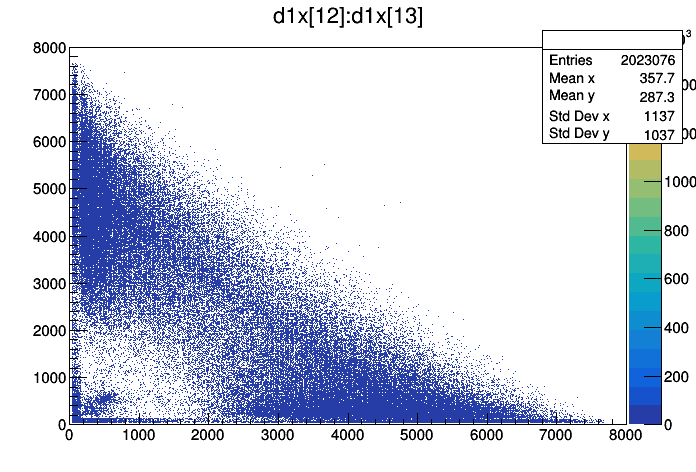

In [2]:
tree->Draw("d1x[12]:d1x[13]>>(1000,0,8000,1000,0,8000)","","colz");//inter-strip correlation
c1->Draw(); //inter-strip events are enhanced by the trigger()

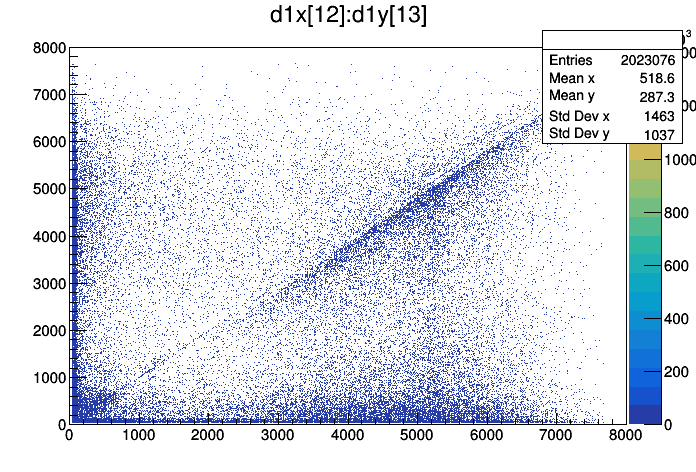

In [3]:
tree->Draw("d1x[12]:d1y[13]>>(1000,0,8000,1000,0,8000)","","colz");
c1->Draw();//front-back correlation 

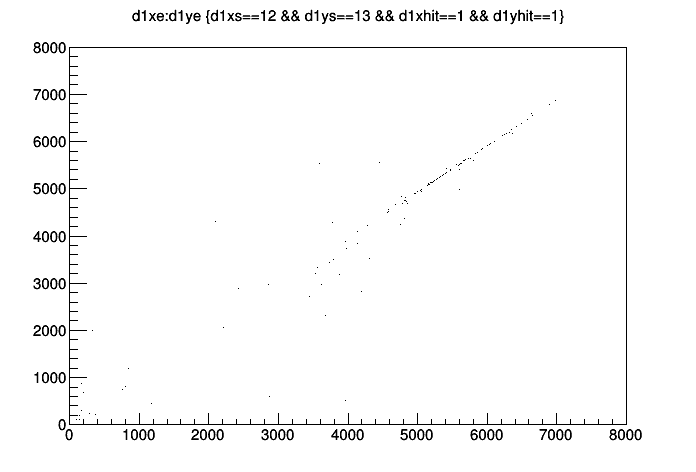

In [4]:
TCut chit="d1xs==12 && d1ys==13 && d1xhit==1 && d1yhit==1";//only one hit in the selected strip
tree->Draw("d1xe:d1ye>>(1000,0,8000,1000,0,8000)",chit,"");//front-back correlation with crosstalk rejection
c1->Draw();//统计不够，是条件太严格所致。

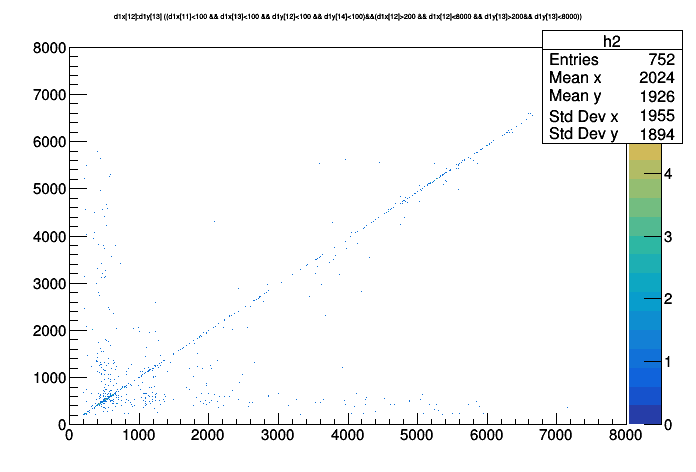

In [5]:
TCut cveto="d1x[11]<100 && d1x[13]<100 && d1y[12]<100 && d1y[14]<100";//no crosstalk from neighbouring strips 
TCut c1213="d1x[12]>200 && d1x[12]<8000 && d1y[13]>200&& d1y[13]<8000";
tree->Draw("d1x[12]:d1y[13]>>h2(1000,0,8000,1000,0,8000)",cveto&&c1213,"colz");//front-back correlation with crosstalk rejection
c1->Draw();

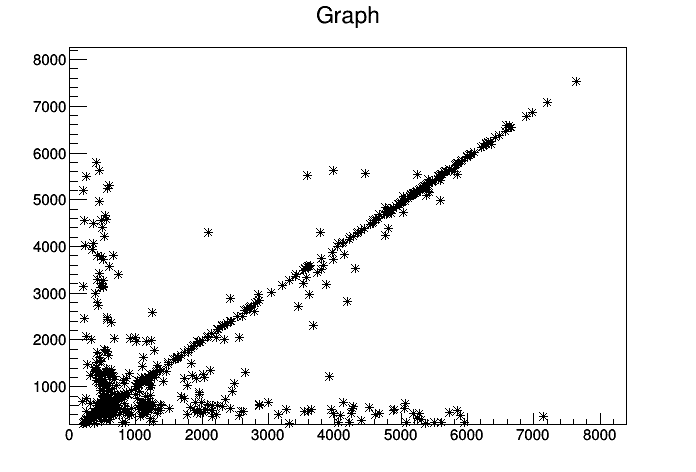

In [6]:
// fill selected tree data to a graph to a graph,
// refers to https://root.cern.ch/root/roottalk/roottalk03/0638.html
TGraph *gr = new TGraph(tree->GetSelectedRows(),tree->GetV2(), tree->GetV1());
gr->Draw("A*");
c1->Draw();


****************************************
Minimizer is Linear
Chi2                      =   1.1529e+09
NDf                       =          750
p0                        =       442.64   +/-   65.0783     
p1                        =     0.732927   +/-   0.0231293   


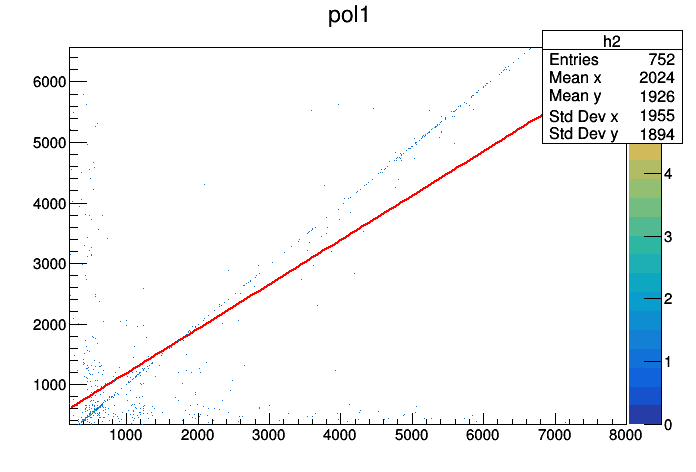

In [7]:
TF1 *fp1= new TF1("fp1","pol1",200,8000);
gr->Fit(fp1);
fp1->Draw();
h2->Draw("colz same");
c1->Draw();

### ROBUST REGRESSION

Robust regression methods are designed to be not overly affected by violations of assumptions by the underlying data-generating process. common situation in which robust estimation is used occurs when the data contain outliers. In the presence of outliers that do not come from the same data-generating process as the rest of the data, least squares estimation is inefficient and can be biased. 
https://root.cern.ch/root/html/tutorials/fit/fitLinearRobust.C.html
![image.png](robust.png)



****************************************
Minimizer is Linear / Robust
Chi2                      =      2207.69
NDf                       =          269
p0                        =      14.3867
p1                        =     0.983132


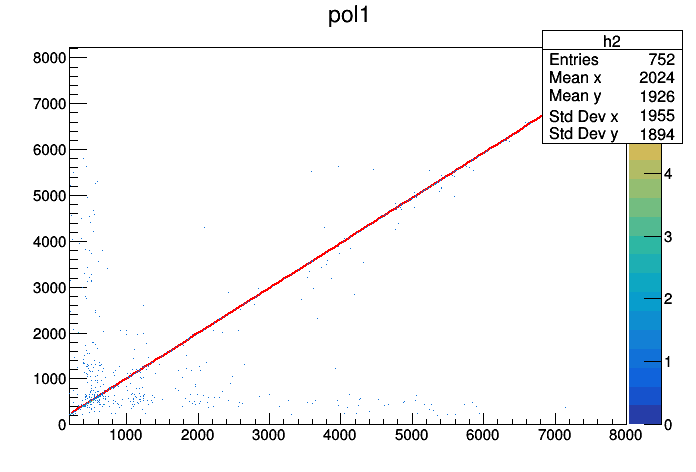

In [16]:
gr->Fit(fp1,"ROB");
   //The option "rob=0.75" means that we want to use robust fitting and
   //we know that at least 75% of data is good points (at least 50% of points
   //should be good to use this algorithm). If you don't specify any number
   //and just use "rob" for the option, default value of (npoints+nparameters+1)/2
   //will be taken
fp1->Draw();
h2->Draw("colz same");
c1->Draw();

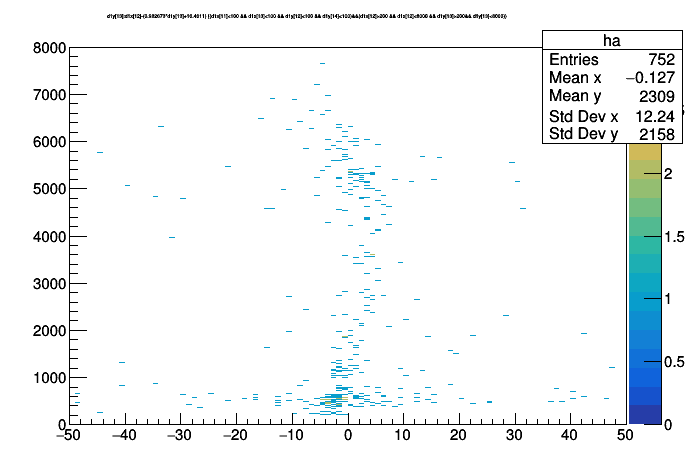

In [8]:
tree->Draw("d1y[13]:d1x[12]-(0.982673*d1y[13]+16.4611)>>ha(100,-50,50,1000,0,8000)",cveto&&c1213,"colz");//front-back correlation with crosstalk rejection
c1->Draw();//从图上看，一次函数拟合并不是很好

In [9]:
//fit graph with ROBUST option, check document for TGraph::Fit() method. 
TF1 *fp2= new TF1("fp2","pol2",200,8000);
gr->Fit(fp2,"ROB");


****************************************
Minimizer is Linear / Robust
Chi2                      =  1.33799e+09
NDf                       =          749
p0                        =      13.2954
p1                        =      0.98693
p2                        = -6.79698e-07


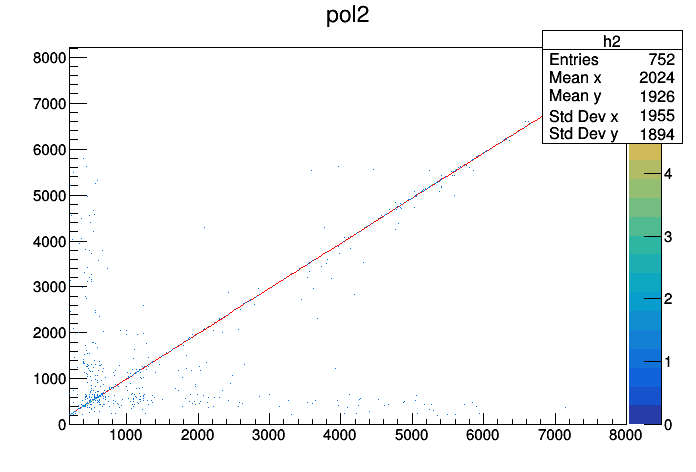

In [10]:
fp2->SetLineWidth(1);
fp2->Draw();
h2->Draw("colz same");
c1->Draw();

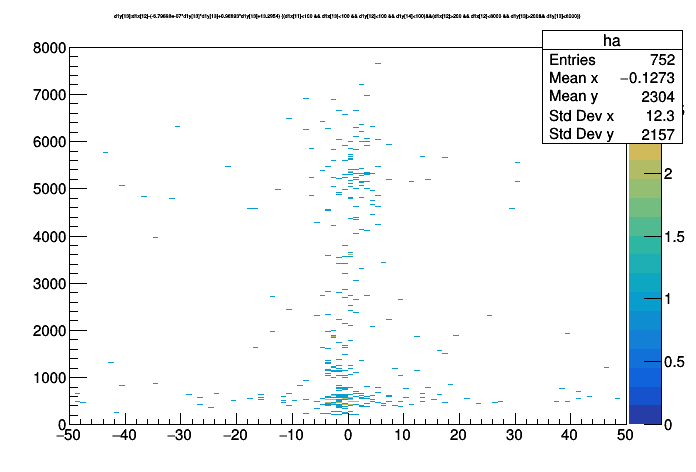

In [11]:
tree->Draw("d1y[13]:d1x[12]-(-6.79698e-07*d1y[13]*d1y[13]+0.98693*d1y[13]+13.2954)>>ha(100,-50,50,1000,0,8000)",cveto&&c1213,"colz");//front-back correlation with crosstalk rejection
c1->Draw();//二次函数拟合比一次函数拟合有显著的改善。


In [12]:
//cut proper range for fit
TCut ccut="abs(d1x[12]-(-6.79698e-07*d1y[13]*d1y[13]+0.98693*d1y[13]+13.2954))<5";

In [13]:
tree->Draw("d1x[12]:d1y[13]>>h2b(1000,0,8000,1000,0,8000)",cveto&&c1213&&ccut,"colz");//front-back correlation with crosstalk rejection
gr = new TGraph(tree->GetSelectedRows(),tree->GetV2(), tree->GetV1());

In [14]:
gr->Fit(fp2,"ROB");


****************************************
Minimizer is Linear / Robust
Chi2                      =      1161.96
NDf                       =          268
p0                        =      12.4199
p1                        =     0.986979
p2                        = -6.27379e-07


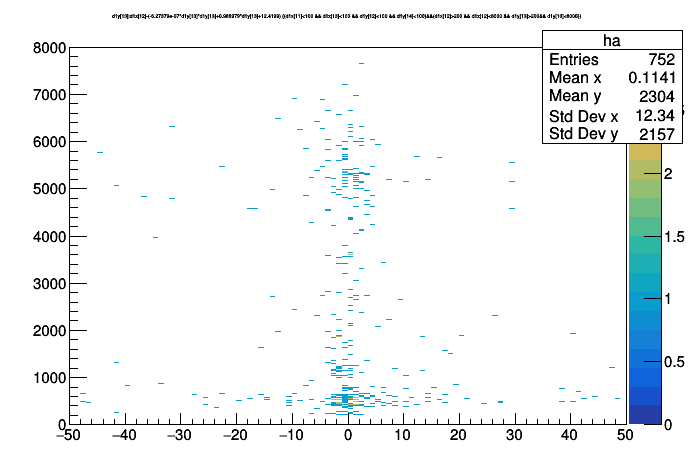

In [15]:
tree->Draw("d1y[13]:d1x[12]-(-6.27379e-07*d1y[13]*d1y[13]+0.986979*d1y[13]+12.4199)>>ha(100,-50,50,1000,0,8000)",cveto&&c1213,"colz");//front-back correlation with crosstalk rejection
c1->Draw();